# House Price Prediction in Bangalore, India

In [1]:
import pandas as pd
import numpy as np

from pandas.io.json import json_normalize

!conda install -c conda-forge folium=0.5.0 --yes
import folium 

!pip install geocoder
import geocoder

import requests

!conda install -c conda-forge geopy --yes 
from geopy.geocoders import Nominatim

from matplotlib import pyplot as plt
%matplotlib inline

import seaborn as sns

from sklearn.preprocessing import LabelEncoder

from sklearn.model_selection import train_test_split

!pip install category_encoders
import category_encoders as ce

from sklearn.metrics import r2_score

from sklearn.ensemble import RandomForestRegressor

!pip install xgboost
from xgboost import XGBRegressor

from sklearn.ensemble import GradientBoostingRegressor

from sklearn.linear_model import Lasso, Ridge

Solving environment: done

## Package Plan ##

  environment location: /opt/conda/envs/Python36

  added / updated specs: 
    - folium=0.5.0


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    altair-4.1.0               |             py_1         614 KB  conda-forge
    branca-0.4.0               |             py_0          26 KB  conda-forge
    openssl-1.1.1f             |       h516909a_0         2.1 MB  conda-forge
    certifi-2020.4.5.1         |   py36h9f0ad1d_0         151 KB  conda-forge
    vincent-0.4.4              |             py_1          28 KB  conda-forge
    ca-certificates-2020.4.5.1 |       hecc5488_0         146 KB  conda-forge
    python_abi-3.6             |          1_cp36m           4 KB  conda-forge
    folium-0.5.0               |             py_0          45 KB  conda-forge
    ------------------------------------------------------------
                       

In [2]:
# Foursquare Credentials 
client_id = '0GE21IKRH3FZODF1RNWDMLN1LUFENFD0EAYCZ3VXT4V4OMAE'
client_secret = '0EO1LG0JP10J3CN5HYFDCCZM3ACMDXPZWPBY1WXQBIQZHXAI'
version = '20201604'
limit = 100

In [3]:
# Get Banglore coordinates
address = "Banglore, India"

geolocator = Nominatim(user_agent="e_tgg")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude

print(address, "coordinates:", latitude, ",", longitude)

Banglore, India coordinates: 18.0056901 , 79.5715088


In [4]:
radius = 500

In [5]:
# Define URL
url = 'https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&ll={},{}&v={}&radius={}&limit={}'.format(
    client_id, 
    client_secret, 
    latitude, 
    longitude, 
    version, 
    radius, 
    limit)
url

'https://api.foursquare.com/v2/venues/explore?client_id=0GE21IKRH3FZODF1RNWDMLN1LUFENFD0EAYCZ3VXT4V4OMAE&client_secret=0EO1LG0JP10J3CN5HYFDCCZM3ACMDXPZWPBY1WXQBIQZHXAI&ll=18.0056901,79.5715088&v=20201604&radius=500&limit=100'

In [6]:
results = requests.get(url).json()
results

{'meta': {'code': 200, 'requestId': '5e9a967b71c428001b068011'},
 'response': {'headerLocation': 'Warangal',
  'headerFullLocation': 'Warangal',
  'headerLocationGranularity': 'city',
  'totalResults': 4,
  'suggestedBounds': {'ne': {'lat': 18.010190104500005,
    'lng': 79.57623170275289},
   'sw': {'lat': 18.001190095499993, 'lng': 79.56678589724712}},
  'groups': [{'type': 'Recommended Places',
    'name': 'recommended',
    'items': [{'reasons': {'count': 0,
       'items': [{'summary': 'This spot is popular',
         'type': 'general',
         'reasonName': 'globalInteractionReason'}]},
      'venue': {'id': '4ea279897ee52a35dce92bf9',
       'name': 'Thousand Pillar Temple',
       'location': {'lat': 18.00426345496528,
        'lng': 79.57485226131779,
        'labeledLatLngs': [{'label': 'display',
          'lat': 18.00426345496528,
          'lng': 79.57485226131779}],
        'distance': 387,
        'cc': 'IN',
        'city': 'Hanamkonda',
        'state': 'Telangana',
 

In [7]:
items = results['response']['groups'][0]['items']
items[0]

{'reasons': {'count': 0,
  'items': [{'summary': 'This spot is popular',
    'type': 'general',
    'reasonName': 'globalInteractionReason'}]},
 'venue': {'id': '4ea279897ee52a35dce92bf9',
  'name': 'Thousand Pillar Temple',
  'location': {'lat': 18.00426345496528,
   'lng': 79.57485226131779,
   'labeledLatLngs': [{'label': 'display',
     'lat': 18.00426345496528,
     'lng': 79.57485226131779}],
   'distance': 387,
   'cc': 'IN',
   'city': 'Hanamkonda',
   'state': 'Telangana',
   'country': 'India',
   'formattedAddress': ['Hanamkonda', 'Telangana', 'India']},
  'categories': [{'id': '4deefb944765f83613cdba6e',
    'name': 'Historic Site',
    'pluralName': 'Historic Sites',
    'shortName': 'Historic Site',
    'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/arts_entertainment/historicsite_',
     'suffix': '.png'},
    'primary': True}],
  'photos': {'count': 0, 'groups': []}},
 'referralId': 'e-0-4ea279897ee52a35dce92bf9-0'}

In [8]:
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [9]:
dataframe = json_normalize(items) 

# Filter columns
filtered_columns = ['venue.name', 'venue.categories'] + [col for col in dataframe.columns if col.startswith('venue.location.')] + ['venue.id']
dataframe_filtered = dataframe.loc[:, filtered_columns]

# Filter the category for each row
dataframe_filtered['venue.categories'] = dataframe_filtered.apply(get_category_type, axis=1)

# Clean columns
dataframe_filtered.columns = [col.split('.')[-1] for col in dataframe_filtered.columns]

# Drop unnecessary columns
dataframe_filtered = dataframe_filtered.drop(["labeledLatLngs", "id", "formattedAddress", "cc"], axis=1)

dataframe_filtered.head()

,name,categories,address,city,country,distance,lat,lng,state
0,Thousand Pillar Temple,Historic Site,NaN,Hanamkonda,India,387,18.004263,79.574852,Telangana
1,Sri Tirumala icecream parlour,Ice Cream Shop,hanamkonda chowrastha,wgl,India,75,18.006117,79.570959,Andhra Pradesh
2,Sri Geeta Bhavan,Restaurant,Hanamkonda Chowrasta,Hanamkonda,India,126,18.006291,79.570493,Telangana
3,KR & MS reddy complex.,Shopping Mall,Hanamkonda,Warangal,India,182,18.004578,79.570241,Telangana


In [10]:
# Plot places
venues_map = folium.Map(location=[latitude, longitude], zoom_start=15) 

folium.features.CircleMarker(
    [latitude, longitude],
    radius=10,
    popup="Hanamkonda Chowarasta, Bangalore",
    fill=True,
    color='red',
    fill_color='red',
    fill_opacity=0.6
    ).add_to(venues_map)

for lat, lng, label in zip(dataframe_filtered.lat, dataframe_filtered.lng, dataframe_filtered.categories):
    folium.features.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        fill=True,
        color='blue',
        fill_color='gray',
        fill_opacity=0.6
        ).add_to(venues_map)

venues_map

Dataset: https://www.kaggle.com/amitabhajoy/bengaluru-house-price-data

In [13]:
# Get data and create the dataframe
import types
import pandas as pd
from botocore.client import Config
import ibm_boto3

def __iter__(self): return 0

@hidden_cell
# The following code accesses a file in your IBM Cloud Object Storage. It includes your credentials.
# You might want to remove those credentials before you share the notebook.
client_e2ac6a322aca43d48c951cbdec7bf59f = ibm_boto3.client(service_name='s3',
    ibm_api_key_id='UT6hosT60thyrSU2Rw7tXluJAtVyl2Q3yyWSgBtxiA9I',
    ibm_auth_endpoint="https://iam.ng.bluemix.net/oidc/token",
    config=Config(signature_version='oauth'),
    endpoint_url='https://s3-api.us-geo.objectstorage.service.networklayer.com')

body = client_e2ac6a322aca43d48c951cbdec7bf59f.get_object(Bucket='capstoneproject-donotdelete-pr-cxqfpflphldt58',Key='Bengaluru_House_Data.csv')['Body']
# add missing __iter__ method, so pandas accepts body as file-like object
if not hasattr(body, "__iter__"): body.__iter__ = types.MethodType( __iter__, body )

# If you are reading an Excel file into a pandas DataFrame, replace `read_csv` by `read_excel` in the next statement.
bangalore = pd.read_csv(body)
bangalore.head(3)

,area_type,availability,location,size,society,total_sqft,bath,balcony,price
0,Super built-up Area,19-Dec,Electronic City Phase II,2 BHK,Coomee,1056,2.0,1.0,39.07
1,Plot Area,Ready To Move,Chikka Tirupathi,4 Bedroom,Theanmp,2600,5.0,3.0,120.00
2,Built-up Area,Ready To Move,Uttarahalli,3 BHK,NaN,1440,2.0,3.0,62.00


In [14]:
# Initial rows
bangalore["price"].count()

13320

In [15]:
def initial_eda(bangalore):
  if isinstance(bangalore, pd.DataFrame):
    total_na = bangalore.isna().sum().sum()
    print("Dimesions: %d rows, %d columns" % (bangalore.shape[0], bangalore.shape[1]))
    print("%38s %10s  %10s %10s" % ("Column name", "Data Type", "#Distinct", "NA Values"))
    col_name = bangalore.columns
    dtyp = bangalore.dtypes
    uniq = bangalore.nunique()
    nan_val = bangalore.isna().sum()
    for i in range(len(bangalore.columns)):
      print("%38s %10s  %10s %10s" % (col_name[i], dtyp[i], uniq[i], nan_val[i]))
    else:
      print("Expect a DF but got a %15s" % (type(bangalore)))

In [16]:
# Empty values 
initial_eda(bangalore)

Dimesions: 13320 rows, 9 columns
                           Column name  Data Type   #Distinct  NA Values
                             area_type     object           4          0
                          availability     object          81          0
                              location     object        1305          1
                                  size     object          31         16
                               society     object        2688       5502
                            total_sqft     object        2117          0
                                  bath    float64          19         73
                               balcony    float64           4        609
                                 price    float64        1994          0
Expect a DF but got a <class 'pandas.core.frame.DataFrame'>


In [17]:
# Remove rows with empty values
bangalore.dropna(axis=0, inplace=True)
initial_eda(bangalore)

Dimesions: 7496 rows, 9 columns
                           Column name  Data Type   #Distinct  NA Values
                             area_type     object           4          0
                          availability     object          74          0
                              location     object         634          0
                                  size     object          15          0
                               society     object        2592          0
                            total_sqft     object        1682          0
                                  bath    float64           8          0
                               balcony    float64           4          0
                                 price    float64        1518          0
Expect a DF but got a <class 'pandas.core.frame.DataFrame'>


In [18]:
# Remaining rows
count = bangalore['location'].count()
print("Count:",count)

Count: 7496


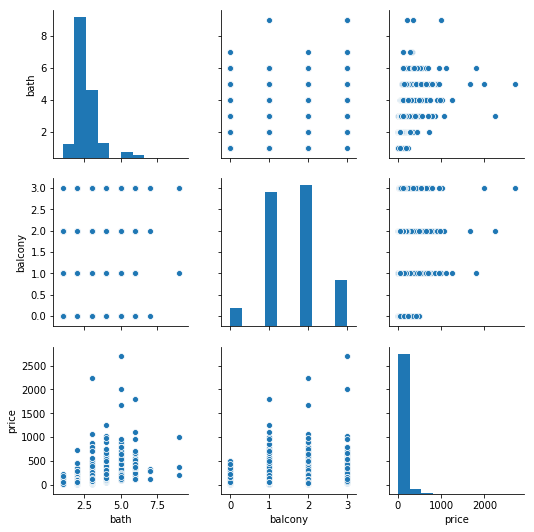

In [19]:
# Barplots and histograms
sns.pairplot(bangalore)
# plt.savefig("pairplot")

Text(0.5, 1.0, 'Heatmap - Pearson Correlation Coefficients')

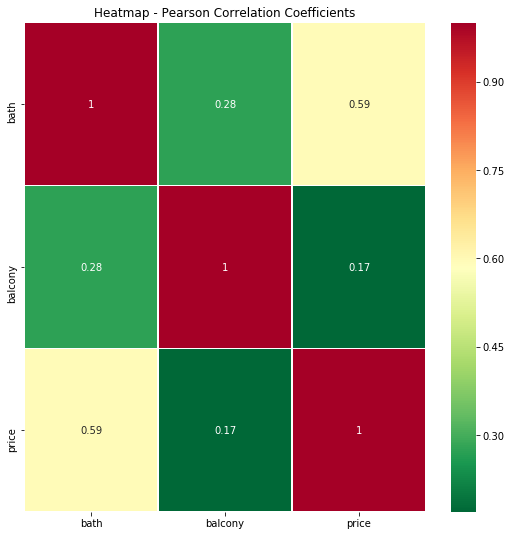

In [20]:
# Pearson correlation coefficients
plt.figure(figsize=(9,9))
sns.heatmap(bangalore.corr(), cmap='RdYlGn_r', linewidths=0.5, annot=True)
plt.title("Heatmap - Pearson Correlation Coefficients")
# plt.savefig("Heatmap")

In [21]:
# House sizes count
var = bangalore.groupby("size").price.count()
var

size
1 BHK         353
1 RK           10
11 BHK          1
2 BHK        3411
2 Bedroom      16
3 BHK        3012
3 Bedroom     120
4 BHK         347
4 Bedroom     193
5 BHK           9
5 Bedroom      16
6 BHK           3
6 Bedroom       3
7 BHK           1
9 BHK           1
Name: price, dtype: int64

Text(0.5, 1.0, 'Area type count')

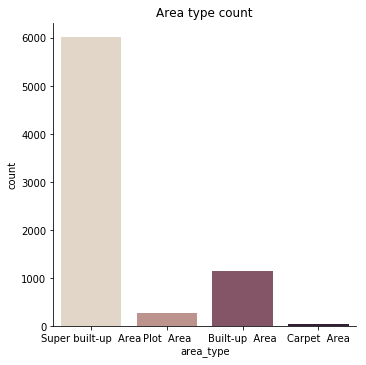

In [22]:
# Area type variable
sns.catplot(x="area_type", kind="count", palette="ch:.25", data=bangalore);
plt.title("Area type count")

Text(0.5, 1.0, 'Boxplots price and area type')

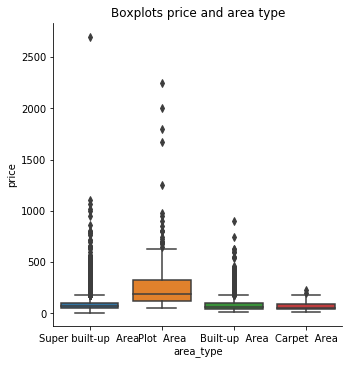

In [23]:
# Boxplots, prices by area types
sns.catplot(x="area_type", y="price", kind="box", data=bangalore)
plt.title("Boxplots price and area type")

In [24]:
bangalore.describe(include=['float'])

,bath,balcony,price
count,7496.000000,7496.000000,7496.000000
mean,2.458378,1.629936,96.857122
std,0.881128,0.780127,105.382490
min,1.000000,0.000000,8.000000
25%,2.000000,1.000000,49.500000
50%,2.000000,2.000000,69.755000
75%,3.000000,2.000000,105.000000
max,9.000000,3.000000,2700.000000


In [25]:
bangalore.describe(include=['object'])

,area_type,availability,location,size,society,total_sqft
count,7496,7496,7496,7496,7496,7496
unique,4,74,634,15,2592,1682
top,Super built-up Area,Ready To Move,Whitefield,2 BHK,GrrvaGr,1200
freq,6017,5709,397,3411,80,172


In [26]:
# Features
x = bangalore.drop(['price'], axis=1)
x[0:3]

,area_type,availability,location,size,society,total_sqft,bath,balcony
0,Super built-up Area,19-Dec,Electronic City Phase II,2 BHK,Coomee,1056,2.0,1.0
1,Plot Area,Ready To Move,Chikka Tirupathi,4 Bedroom,Theanmp,2600,5.0,3.0
3,Super built-up Area,Ready To Move,Lingadheeranahalli,3 BHK,Soiewre,1521,3.0,1.0


In [27]:
# Target
y = bangalore['price']
y[0:3]

0     39.07
1    120.00
3     95.00
Name: price, dtype: float64

In [28]:
# Train_test_split 
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.3, random_state = 0)

print('Train set:', x_train.shape,  y_train.shape)
print('Test set:', x_test.shape,  y_test.shape)

Train set: (5247, 8) (5247,)
Test set: (2249, 8) (2249,)


In [29]:
# Categorical variables
cats = [ftr for ftr in x_train.columns if x_train[ftr].dtypes == 'O']
cats

['area_type', 'availability', 'location', 'size', 'society', 'total_sqft']

In [30]:
# One Hot Encoder
enc_onehot = ce.OneHotEncoder(cols=cats)

x_train = enc_onehot.fit_transform(x_train)
x_test = enc_onehot.transform(x_test)

In [31]:
# Plot function
def DistributionPlot(RedFunction, BlueFunction, RedName, BlueName, Title):
    width = 12
    height = 7
    plt.figure(figsize=(width, height))

    ax1 = sns.distplot(RedFunction, hist=False, color="r", label=RedName)
    ax2 = sns.distplot(BlueFunction, hist=False, color="b", label=BlueName, ax=ax1)

    plt.title(Title)
    plt.xlabel('Price')

    plt.show()
    plt.close()

In [32]:
# Random Forest
model = RandomForestRegressor()
model.fit(x_train, y_train)
y_train_hat = model.predict(x_test)
y_test_hat = model.predict(x_test)

/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [33]:
# Evaluation
print("Mean absolute error: %.2f" % np.mean(np.absolute(y_test_hat - y_test)))
print("Residual sum of squares (MSE): %.2f" % np.mean((y_test_hat - y_test)**2))
r2_rf = r2_score(y_test_hat, y_test)
print("R2-score: %.4f" % r2_rf)

Mean absolute error: 22.50
Residual sum of squares (MSE): 4277.01
R2-score: 0.0814


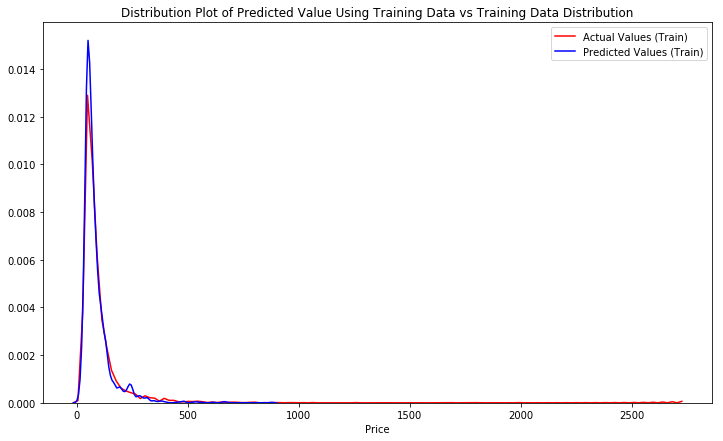

In [34]:
Title = 'Distribution Plot of Predicted Value Using Training Data vs Training Data Distribution'
DistributionPlot(y_train, y_train_hat, "Actual Values (Train)", "Predicted Values (Train)", Title)

In [35]:
# XGBoost 
model = XGBRegressor()
model.fit(x_train, y_train)
y_train_hat = model.predict(x_test)
y_test_hat = model.predict(x_test)

In [36]:
# Evaluation
print("Mean absolute error: %.2f" % np.mean(np.absolute(y_test_hat - y_test)))
print("Residual sum of squares (MSE): %.2f" % np.mean((y_test_hat - y_test)**2))
r2_xgb = r2_score(y_test_hat, y_test)
print("R2-score: %.4f" % r2_xgb)

Mean absolute error: 26.24
Residual sum of squares (MSE): 4095.41
R2-score: 0.2862


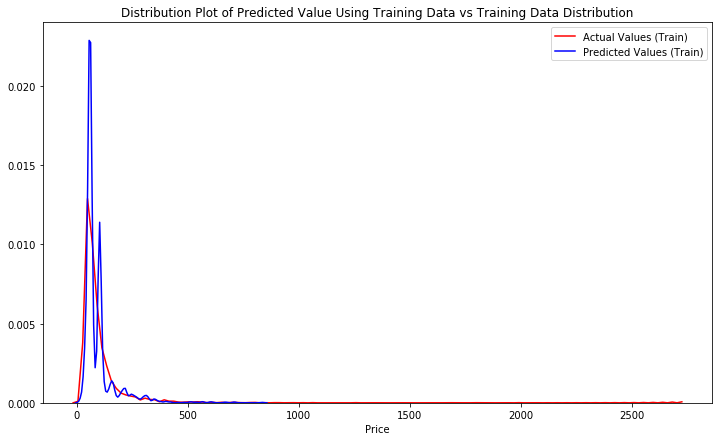

In [37]:
DistributionPlot(y_train, y_train_hat, "Actual Values (Train)", "Predicted Values (Train)", Title)

In [38]:
# Gradient Boosting
model = GradientBoostingRegressor()
model.fit(x_train, y_train)
y_train_hat = model.predict(x_test)
y_test_hat = model.predict(x_test)

In [39]:
# Evaluation
print("Mean absolute error: %.2f" % np.mean(np.absolute(y_test_hat - y_test)))
print("Residual sum of squares (MSE): %.2f" % np.mean((y_test_hat - y_test)**2))
r2_grb = r2_score(y_test_hat, y_test)
print("R2-score: %.4f" % r2_grb)

Mean absolute error: 32.14
Residual sum of squares (MSE): 4945.79
R2-score: -0.1315


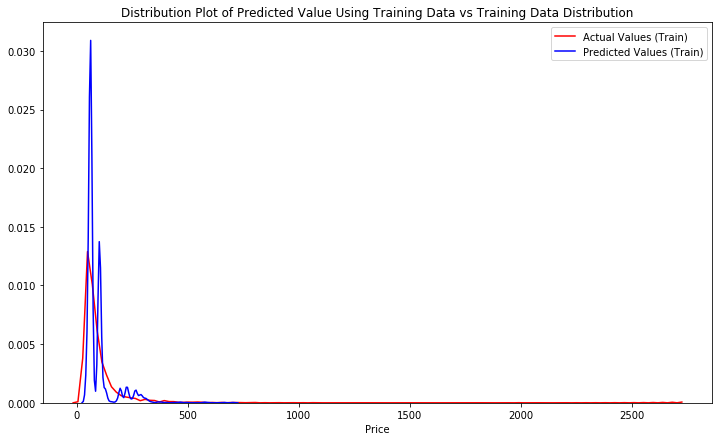

In [40]:
DistributionPlot(y_train, y_train_hat, "Actual Values (Train)", "Predicted Values (Train)", Title)

In [41]:
# Lasso Regression 
model = Lasso()
model.fit(x_train, y_train)
y_train_hat = model.predict(x_test)
y_test_hat = model.predict(x_test)

In [42]:
# Evaluation
print("Mean absolute error: %.2f" % np.mean(np.absolute(y_test_hat - y_test)))
print("Residual sum of squares (MSE): %.2f" % np.mean((y_test_hat - y_test)**2))
r2_lasso = r2_score(y_test_hat, y_test)
print("R2-score: %.4f" % r2_lasso)

Mean absolute error: 35.60
Residual sum of squares (MSE): 6026.51
R2-score: -0.4364


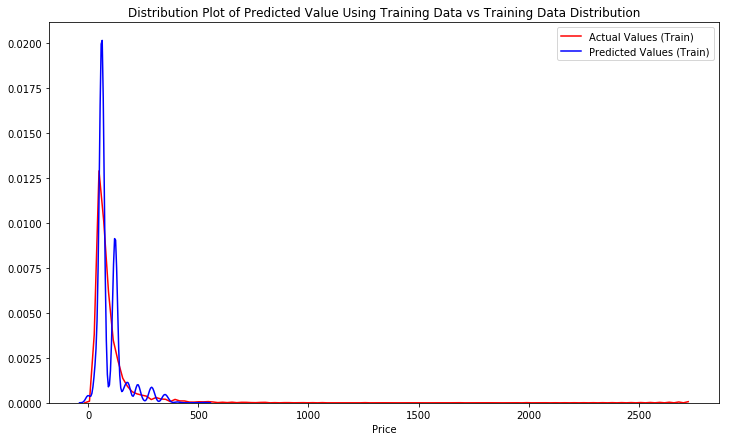

In [43]:
DistributionPlot(y_train, y_train_hat, "Actual Values (Train)", "Predicted Values (Train)", Title)

In [44]:
# Ridge Regression 
model = Ridge()
model.fit(x_train, y_train)
y_train_hat = model.predict(x_test)
y_test_hat = model.predict(x_test)

In [45]:
# Evaluation
print("Mean absolute error: %.2f" % np.mean(np.absolute(y_test_hat - y_test)))
print("Residual sum of squares (MSE): %.2f" % np.mean((y_test_hat - y_test)**2))
r2_ridge = r2_score(y_test_hat, y_test)
print("R2-score: %.4f" % r2_ridge)

Mean absolute error: 21.95
Residual sum of squares (MSE): 3471.91
R2-score: 0.4165


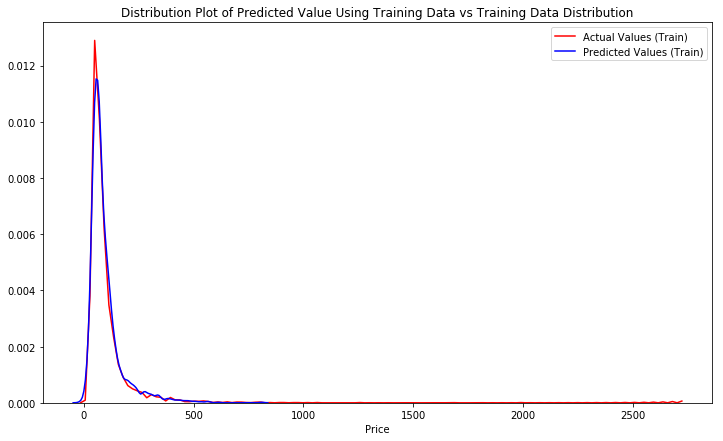

In [46]:
DistributionPlot(y_train, y_train_hat, "Actual Values (Train)", "Predicted Values (Train)", Title)

In [47]:
# R^2 scores
print("Random Forest r^2-score: %.4f" % r2_rf)
print("XGBoost r^2-score: %.4f" % r2_xgb)
print("Gradient Boosting r^2-score: %.4f" % r2_grb)
print("Lasso Regression r^2-score: %.4f" % r2_lasso)
print("Ridge Regression r^2-score: %.4f" % r2_ridge)

Random Forest r^2-score: 0.0814
XGBoost r^2-score: 0.2862
Gradient Boosting r^2-score: -0.1315
Lasso Regression r^2-score: -0.4364
Ridge Regression r^2-score: 0.4165


**Thanks for reading!**